In [1]:
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper
from mlagents_envs.environment import ActionTuple, UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import \
    EngineConfigurationChannel
from mlagents_envs.exception import (
    UnityEnvironmentException,
    UnityCommunicationException,
    UnityCommunicatorStoppedException,
)
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import collections
from typing import Union
import math
import random
from copy import deepcopy
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.distributions as distr
from fastprogress import progress_bar as pb
import matplotlib.pyplot as plt
import pandas as pd

/home/ym/.cache/pypoetry/virtualenvs/mlagent-learn-20-test-54-2MrXv-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class NStepPriorityReplayBuffer:

    def __init__(
        self,
        max_size: int,
        prob_alpha: float = 0.6,
        beta_start: float = 0.4,
        beta_frames: float = 100000,
        n_step: int = 4,
        gamma: float = 0.99,
    ):
        self._prob_alpha = prob_alpha
        self._max_size = max_size
        self._pos = 0
        self._buf = []
        self._priorities = np.zeros((max_size,), dtype=np.float32)
        self._beta_start = beta_start
        self._beta = beta_start
        self._beta_frames = beta_frames
        self._n_step = n_step
        self._gamma = gamma
        self._total_discounted_rewards = np.array([np.nan]*max_size)
        self._last_states = [np.nan]*max_size

    def update_bata(self, idx) -> None:
        beta = self._beta_start + idx * (1.0 - self._beta_start) / self._beta_frames
        self._beta = min(1.0, beta)
        return self._beta

    def __len__(self):
        return len(self._buf)

    def append(
        self,
        state: np.ndarray,
        action: int,
        reward: Union[int, float],
        done: bool,
        next_state: np.ndarray,
    ) -> None:
        max_prio = self._priorities.max() if self._buf else 1.0
        if len(self._buf) < self._max_size:
            self._buf.append(
                (state, action, reward, done, next_state)
            )
        else:
            self._buf[self._pos] = (state, action, reward, done, next_state)
        self._priorities[self._pos] = max_prio

        if len(self._buf) >= self._n_step:
            dis_r = 0.0
            last_state = self._buf[self._pos][0]
            for i in range(self._n_step):
                state, _, r, done, _ = self._buf[self._pos - i]
                dis_r = r + self._gamma * dis_r
                if done:
                    last_state = state
                    dis_r = r
                self._total_discounted_rewards[self._pos - i] = dis_r
                self._last_states[self._pos - i] = last_state
            
            for i in range(self._n_step-1):
                done = self._buf[self._pos - i][3]
                if done:
                    break
                self._total_discounted_rewards[self._pos - i] = np.nan
                self._last_states[self._pos - i] = np.nan

        self._pos = (self._pos + 1) % self._max_size

    def sample(self, size: int):
        sample_target_indices = np.where(~np.isnan(self._total_discounted_rewards[:len(self._buf)]))[0]
        # prios = self._priorities[sample_target_indices]  #self._priorities if len(self._buf) == self._max_size else self._priorities[:self._pos]
        prios = self._priorities
        probs = prios * self._prob_alpha
        # probs /= np.nan_to_num(probs, 0.0).sum()
        probs /= probs[sample_target_indices].sum()
        sampled_indices = np.random.choice(
            sample_target_indices,
            # np.where(~np.isnan(self._total_discounted_rewards[:len(self._buf)]))[0],
            size, p=probs[sample_target_indices]
        )
        states, actions, rewards, dones, next_states = zip(*[self._buf[idx] for idx in sampled_indices])
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)
        next_states = np.array(next_states)
        total_discounted_rewards = self._total_discounted_rewards[sampled_indices]
        last_states = np.stack([self._last_states[idx] for idx in sampled_indices])
        total = len(self._buf)
        weights = np.array((total * probs[sampled_indices]) ** (-self._beta), dtype=np.float32)
        # weights = np.array((total * probs) ** (-self._beta), dtype=np.float32)
        weights /= weights.max()
        return states, actions, rewards, dones, total_discounted_rewards, last_states, sampled_indices, weights

    def update_priorities(self, sample_indices: np.ndarray, sample_priorities: np.ndarray) -> None:
        self._priorities[sample_indices] = sample_priorities

    @property
    def gamma(self) -> float:
        return self._gamma

    @property
    def n_step(self) -> float:
        return self._n_step

In [4]:
class NoisyLinear(nn.Linear):

    def __init__(self, in_features, out_features, sigma_init=0.017, bias=True):
        super(NoisyLinear, self).__init__(in_features, out_features, bias=bias)
        w = torch.full((out_features, in_features), sigma_init)
        self._sigma_weight = nn.Parameter(w)
        z = torch.zeros(out_features, in_features)
        self.register_buffer("epsilon_weight", z)
        if bias:
            w = torch.full((out_features,), sigma_init)
            self._sigma_bias = nn.Parameter(w)
            z = torch.zeros(out_features)
            self.register_buffer("epsilon_bias", z)
        self.reset_parameters()

    def reset_parameters(self):
        std = math.sqrt(3 / self.in_features)
        self.weight.data.uniform_(-std, std)
        self.bias.data.uniform_(-std, std)

    def forward(self, input):
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self._sigma_bias * \
                   self.epsilon_bias.data
        v = self._sigma_weight * self.epsilon_weight.data + \
            self.weight
        return F.linear(input, v, bias)

In [5]:
class SACActor(nn.Module):

    def __init__(self, obs_size, act_size, hidden_size: int = 64):
        super(SACActor, self).__init__()

        self.mu = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, act_size),
            nn.Softmax(-1),
        )
        self.logstd = nn.Parameter(torch.zeros(act_size))

    def forward(self, x):
        return self.mu(x)

In [6]:
class SACCritic(nn.Module):

    def __init__(self, obs_size, hidden_size: int = 64):
        super(SACCritic, self).__init__()

        self.value = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        return self.value(x)

In [7]:
class SACTwinQ(nn.Module):

    def __init__(self, obs_size, act_size, hidden_size: int = 64):
        super(SACTwinQ, self).__init__()

        self.q1 = nn.Sequential(
            nn.Linear(obs_size + act_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

        self.q2 = nn.Sequential(
            nn.Linear(obs_size + act_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=1)
        return self.q1(x), self.q2(x)

In [21]:
class Agent:

    def __init__(
        self,
        env,
        exp_buffer: NStepPriorityReplayBuffer,
        act_net: nn.Module,
        crt_net: nn.Module,
        twinq_net:  nn.Module,
        epsilon_start: float = 1.0,
        epsilon_final: float = 0.01,
        epsilon_decay_last_step: int = 200000,
        tgt_sync_steps: int = 10000,
        learning_rate_acts: float = 1e-4,
        learning_rate_vals: float = 1e-4,
        adam_eps: float = None,
        sac_entropy_alpha: float = 0.1,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ):
        self._env = env
        self._exp_buffer = exp_buffer
        self._act_net = act_net
        self._crt_net = crt_net
        self._twinq_net = twinq_net
        self._tgt_act_net = deepcopy(act_net)
        self._tgt_crt_net = deepcopy(crt_net)
        for p in self._tgt_act_net.parameters():
            p.requires_grad = False
        for p in self._tgt_crt_net.parameters():
            p.requires_grad = False
        self._epsilon_start = epsilon_start
        self._epsilon_final = epsilon_final
        self._epsilon_decay_last_step = epsilon_decay_last_step
        self._epsilon = epsilon_start
        self._device = device
        self._total_step = 0
        self._total_trained_samples = 0
        self._tgt_sync_steps = tgt_sync_steps
        adam_kwargs = {}
        if adam_eps is not None:
            adam_kwargs['eps'] = adam_eps
        self._crt_optimizer = torch.optim.Adam(self._crt_net.parameters(), lr=learning_rate_vals, **adam_kwargs)
        self._act_optimizer = torch.optim.Adam(self._act_net.parameters(), lr=learning_rate_acts, **adam_kwargs)
        self._twinq_optimizer = torch.optim.Adam(self._twinq_net.parameters(), lr=learning_rate_vals, **adam_kwargs)
        self._sac_entropy_alpha = sac_entropy_alpha
        self._reset_episode()

    def _reset_episode(self):
        self._state = self._env.reset()
        self._total_reward = 0.0

    @torch.no_grad()
    def play_step(
        self,
        epsilon: Optional[float] = None,
        sync_target: bool = True,
        probabilistic_decision: bool = True,
    ):
        if epsilon is None:
            epsilon = self._epsilon
        done_reward = None

        if np.random.random() < epsilon:
            action_discrete = self._env.action_space.sample()
            action = np.zeros(self._env.action_space.n)
            action[action_discrete] = 1.0
        else:
            state_a = np.array([self._state], copy=False)
            state_v = torch.tensor(state_a).float().to(self._device)
            mu_v = self._act_net(state_v)
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            # action = np.clip(action, -1, 1)
            if probabilistic_decision:
                action_discrete = np.random.choice(range(len(action)), size=1, p=action).astype(int)[0]
            else:
                action_discrete = action.argmax()

        next_state, reward, is_done, _ = self._env.step(action_discrete)
        self._total_reward += reward

        self._exp_buffer.append(
            self._state, action, reward, is_done, next_state
        )
        self._state = next_state
        if is_done:
            done_reward = self._total_reward
            self._reset_episode()

        self._total_step += 1
        self._update_epsilon(self._total_step)
        self._exp_buffer.update_bata(self._total_step)

        # if self._total_step % self._tgt_sync_steps == 0 and sync_target:
        #     self._alpha_sync(self._act_net, self._tgt_act_net, alpha=1 - 1e-3)
        #     self._alpha_sync(self._crt_net, self._tgt_crt_net, alpha=1 - 1e-3)
        #     print(f'synced target net')

        return done_reward

    def train(self, n_iter: int = 1, batch_size: int = 32) -> None:
        n_step_gamma = self._exp_buffer.gamma ** self._exp_buffer.n_step
        for i in range(n_iter):
            states, actions, rewards, dones, total_discounted_rewards, \
                last_states, sampled_indices, weights = self._exp_buffer.sample(batch_size)
            states_v = torch.tensor(states).float().to(self._device)
            actions_v = torch.tensor(actions).float().to(self._device)
            discounted_rewards_v = torch.tensor(total_discounted_rewards).to(self._device)
            done_mask = torch.BoolTensor(dones).to(self._device)
            weights_v = torch.tensor(weights).to(self._device)
            last_states_v = torch.tensor(last_states).float().to(self._device)

            # last_act_v = self._tgt_act_net(last_states_v)
            q_last_v = self._tgt_crt_net(last_states_v)
            q_last_v[done_mask] = 0.0
            q_ref_v = discounted_rewards_v.unsqueeze(dim=-1) + \
                        q_last_v * n_step_gamma

            mu_v = self._act_net(states_v)
            act_dist = distr.Normal(mu_v, torch.exp(self._act_net.logstd))
            acts_v = act_dist.sample()
            q1_v, q2_v = self._twinq_net(states_v, acts_v)
            # element-wise minimum
            vals_ref_v = torch.min(q1_v, q2_v).squeeze() - \
                        self._sac_entropy_alpha * act_dist.log_prob(acts_v).sum(dim=1)

            # train TwinQ
            self._twinq_optimizer.zero_grad()
            q1_v, q2_v = self._twinq_net(states_v, actions_v)
            q1_loss_v = F.mse_loss(q1_v.squeeze().float(),
                                    q_ref_v.squeeze().detach().float())
            q2_loss_v = F.mse_loss(q2_v.squeeze().float(),
                                    q_ref_v.squeeze().detach().float())
            q_loss_v = q1_loss_v + q2_loss_v
            q_loss_v.backward()
            self._twinq_optimizer.step()

            # Critic
            self._crt_optimizer.zero_grad()
            val_v = self._crt_net(states_v)
            v_loss_v = F.mse_loss(val_v.squeeze().float(),
                                    vals_ref_v.squeeze().detach().float())
            v_loss_v.backward()
            self._crt_optimizer.step()

            # Actor
            self._act_optimizer.zero_grad()
            acts_v = self._act_net(states_v)
            q_out_v, _ = self._twinq_net(states_v, acts_v)
            act_loss = -q_out_v.mean()
            act_loss.backward()
            self._act_optimizer.step()

            # self._alpha_sync(self._act_net, self._tgt_act_net, alpha=1 - 1e-3)
            self._alpha_sync(self._crt_net, self._tgt_crt_net, alpha=1 - 1e-3)

            # self._exp_buffer.update_priorities(sampled_indices, prios)
            self._total_trained_samples += batch_size

    def initial_exploration(self, n_steps: int = 10000, epsilon: float = 1.0) -> None:
        eps_bak = self._epsilon
        try:
            for i in pb(range(n_steps)):
                self._epsilon = epsilon
                self.play_step(sync_target=False)
        finally:
            self._total_step = 0
            self._epsilon = eps_bak

    def _update_epsilon(self, step_index: int) -> None:
        self._epsilon = max(
            self._epsilon_final,
            self._epsilon_start - step_index / self._epsilon_decay_last_step
        )

    def _sync(self, net, tgt_net):
        tgt_net.load_state_dict(net.state_dict())

    def _alpha_sync(self, net, tgt_net, alpha):
        assert isinstance(alpha, float)
        assert 0.0 < alpha <= 1.0
        state = net.state_dict()
        tgt_state = tgt_net.state_dict()
        for k, v in state.items():
            tgt_state[k] = tgt_state[k] * alpha + (1 - alpha) * v
        tgt_net.load_state_dict(tgt_state)


In [9]:
class UnityToGymNumpyWrapper(UnityToGymWrapper):
    def __init__(self, *args, **kwargs):
        super(UnityToGymNumpyWrapper, self).__init__(*args, **kwargs)

    def reset(self, *args, **kwargs):
        state = super().reset(*args, **kwargs)
        return np.array(state[0])

    def step(self, *args, **kwargs):
        next_state, reward, is_done, info = super().step(*args, **kwargs)
        return np.array(next_state[0]), reward, is_done, info

In [10]:
try:
    unity_env.close()
except Exception:
    pass

unity_env = UnityEnvironment(file_name=None)

In [11]:
unity_env.reset()

In [12]:
# env = UnityToGymWrapper(unity_env, allow_multiple_obs=True)
env = UnityToGymNumpyWrapper(unity_env, allow_multiple_obs=True)

In [13]:
# Unity環境のリセット
unity_env.reset()

# BehaviorNameのリストの取得
behavior_names = list(unity_env.behavior_specs.keys())
print('behavior_names:', behavior_names)

# BehaviorSpecの取得
behavior_spec = unity_env.behavior_specs[behavior_names[0]]

# BehaviorSpecの情報の確認
print('\n== BehaviorSpecの情報の確認 ==')
print('observation_specs:', behavior_spec.observation_specs)
print('action_spec:', behavior_spec.action_spec)

behavior_names: ['Basic?team=0']

== BehaviorSpecの情報の確認 ==
observation_specs: [ObservationSpec(shape=(20,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='Basic')]
action_spec: Continuous: 0, Discrete: (3,)


In [14]:
behavior_spec

BehaviorSpec(observation_specs=[ObservationSpec(shape=(20,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='Basic')], action_spec=ActionSpec(continuous_size=0, discrete_branches=(3,)))

In [15]:
# 現在のステップの情報の取得
decision_steps, terminal_steps = unity_env.get_steps(behavior_names[0])

# DecisionStepsの情報の確認
print('\n== DecisionStepsの情報の確認 ==')
print('obj:', decision_steps.obs)
print('reward:', decision_steps.reward)
print('agent_id:', decision_steps.agent_id)
print('action_mask:', decision_steps.action_mask)

# TerminalStepsの情報の確認
print('\n== TerminalStepsの情報の確認 ==')
print('obs:', terminal_steps.obs)
print('reward:', terminal_steps.reward)
print('agent_id:', terminal_steps.agent_id)
print('interrupted:', terminal_steps.interrupted)


== DecisionStepsの情報の確認 ==
obj: [array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)]
reward: [-0.01]
agent_id: [0]
action_mask: [array([[False, False, False]])]

== TerminalStepsの情報の確認 ==
obs: [array([], shape=(0, 20), dtype=float32)]
reward: []
agent_id: []
interrupted: []


In [16]:
len(decision_steps.obs)

1

In [17]:
decision_steps.obs[0].shape

(1, 20)

In [18]:
# N_AGENTS, OBS_DIM = decision_steps.obs[0].shape

In [19]:
# N_ACTIONS = behavior_spec.action_spec.continuous_size

In [20]:
env.action_space

Discrete(3)

In [22]:
N_ACTIONS = env.action_space.n

In [23]:
N_ACTIONS

3

In [24]:
env.action_space.sample()

0

In [25]:
env.observation_space

Tuple(Box(-inf, inf, (20,), float32))

In [26]:
OBS_DIM = env.observation_space[0].shape[0]

In [27]:
OBS_DIM

20

In [28]:
state = env.reset()

In [29]:
state

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [30]:
state.shape

(20,)

In [31]:
SEED = 77

In [32]:
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
act_net = SACActor(
    OBS_DIM,
    N_ACTIONS
).to(device)
crt_net = SACCritic(
    OBS_DIM,
    N_ACTIONS
).to(device)
twinq_net = SACTwinQ(
    OBS_DIM,
    N_ACTIONS
).to(device)

In [34]:
act = act_net(torch.tensor(state).unsqueeze(0).to(device))

In [35]:
act.shape

torch.Size([1, 3])

In [36]:
v = crt_net(torch.tensor(state).unsqueeze(0).to(device))

In [37]:
v.shape

torch.Size([1, 1])

In [38]:
exp_buffer = NStepPriorityReplayBuffer(
    max_size=60000,
    prob_alpha=0.6,
    beta_start=0.4,
    beta_frames=30000, #100000,
    n_step=10,
    gamma=0.99,
)

In [39]:
agent = Agent(
    env=env,
    exp_buffer=exp_buffer,
    crt_net=crt_net,
    act_net=act_net,
    twinq_net=twinq_net,
    epsilon_start=0.3,
    epsilon_final=0.002,
    epsilon_decay_last_step=50000, #200000,
    # tgt_sync_steps=1000,
    learning_rate_acts=1e-5,
    learning_rate_vals=1e-5,
    device=device
)

In [40]:
agent.initial_exploration(n_steps=10000)

In [41]:
states, actions, rewards, dones, next_states = zip(*agent._exp_buffer._buf)

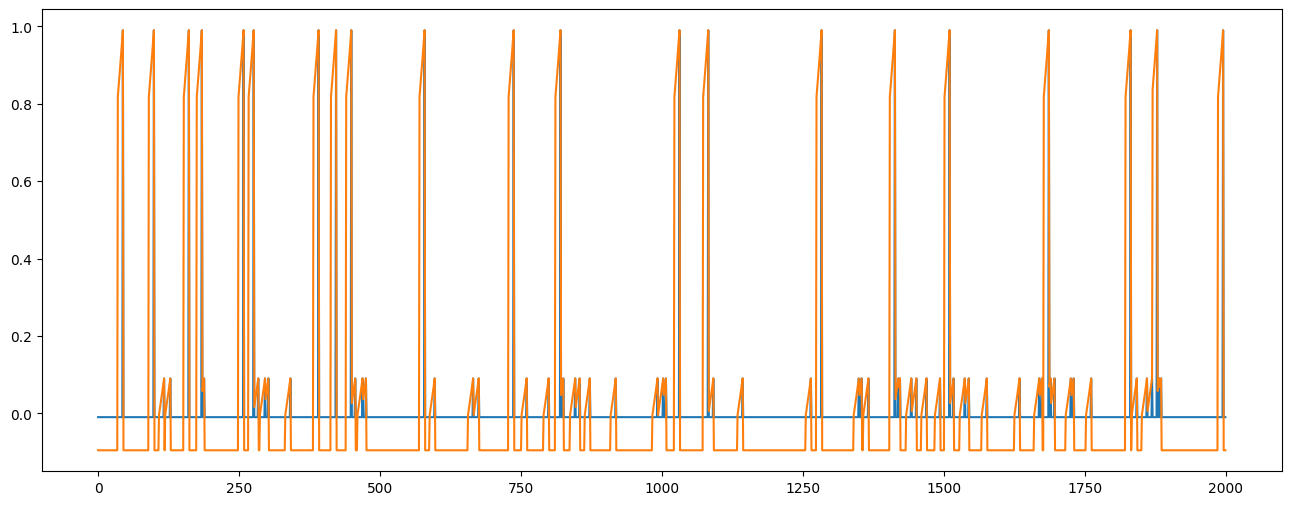

In [42]:
plt.figure(figsize=(16, 6))
plt.plot(rewards[:2000])
plt.plot(agent._exp_buffer._total_discounted_rewards[:2000])

In [43]:
# n_step=10
# learning_rate_acts=1e-5,
# learning_rate_vals=1e-5,
episode = 0
reward_history = []
spisode_steps_history = []
spisode_start_steps = 0

env.reset()

while True:

    for stp in range(1):
        done_reward = agent.play_step()
        if done_reward is not None:
            print(f'episode : {episode}, done reward : {done_reward}, total_step : {agent._total_step}, cur_epsilon : {agent._epsilon}')
            episode += 1
            reward_history.append(done_reward)
            spisode_steps_history.append(agent._total_step-spisode_start_steps)
            spisode_start_steps = agent._total_step

    agent.train(n_iter=1, batch_size=64)

episode : 0, done reward : -0.02999996766448021, total_step : 69, cur_epsilon : 0.29862
episode : 1, done reward : 0.7100000157952309, total_step : 98, cur_epsilon : 0.29803999999999997
episode : 2, done reward : 0.610000018030405, total_step : 137, cur_epsilon : 0.29725999999999997
episode : 3, done reward : 0.3500000238418579, total_step : 202, cur_epsilon : 0.29596
episode : 4, done reward : -0.11999999172985554, total_step : 224, cur_epsilon : 0.29552
episode : 5, done reward : -0.3499999865889549, total_step : 269, cur_epsilon : 0.29462
episode : 6, done reward : 0.7900000140070915, total_step : 290, cur_epsilon : 0.2942
episode : 7, done reward : -0.1399999912828207, total_step : 314, cur_epsilon : 0.29372
episode : 8, done reward : -0.3599999863654375, total_step : 360, cur_epsilon : 0.2928
episode : 9, done reward : 0.040000004693865776, total_step : 366, cur_epsilon : 0.29268
episode : 10, done reward : -0.7399999778717756, total_step : 450, cur_epsilon : 0.291
episode : 11, d

KeyboardInterrupt: 

Text(0, 0.5, 'episode total reward')

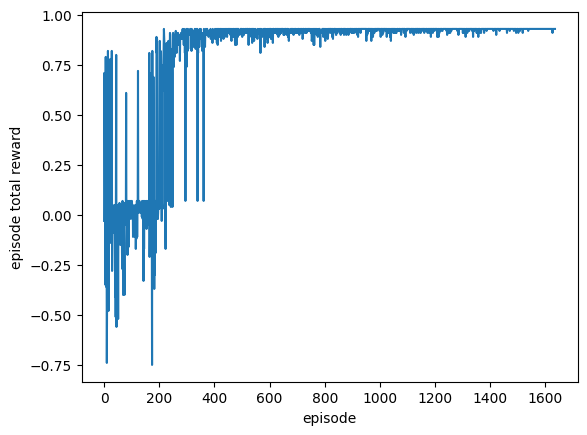

In [44]:
plt.plot(reward_history)
plt.xlabel('episode')
plt.ylabel('episode total reward')

Text(0, 0.5, 'episode total reward')

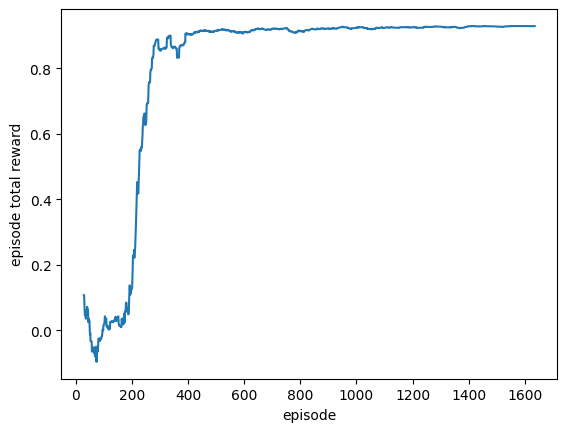

In [45]:
pd.Series(reward_history).rolling(window=30).mean().plot()
plt.xlabel('episode')
plt.ylabel('episode total reward')

In [46]:
env.close()